<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import sys
import os
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-darkgrid')

In [3]:
sys.path.append('../src')

In [4]:
from prediction.models import gompertz_simple, exp_cdf_nonorm, tanh_KM_cdf, gompertz_cdf_nonorm
from prediction.plot import plot_results_fit

In [5]:
from preprocessing.andalucia import ods_to_dataframe, preprocess_andalucia
from prediction.prediction import preprocess_data
from prediction.fit import temporal_validation_metric, fit_model
path = "../data/series_provincias_andalucia.csv"

df = pd.read_csv(path)
df = preprocess_andalucia(df)
# df.set_index("dia", inplace=True)
df['region'] = df['region'].replace({'andalucia':'total'})
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 234 entries, 2020-03-14 to 2020-04-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   region       234 non-null    object
 1   resultado  234 non-null    int64 
 2   ingreso    234 non-null    int64 
 3   uci        234 non-null    int64 
 4   defuncion  234 non-null    int64 
 5   curado     234 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 12.8+ KB


In [6]:
df.head()

,region,resultado,ingreso,uci,defuncion,curado
dia,,,,,,
2020-03-14,almeria,14,0,0,0,0
2020-03-15,almeria,14,1,0,0,0
2020-03-16,almeria,23,1,1,0,0
2020-03-17,almeria,26,3,0,0,0
2020-03-18,almeria,30,3,0,0,0


[5926.5348345   728.31580751   19.09034318]


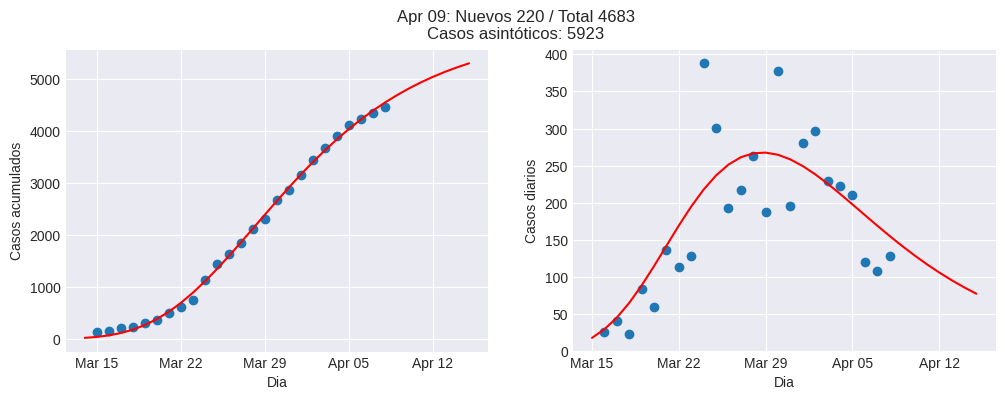

In [9]:
fecha_inicio = dt.datetime(2020, 3, 1)

x, y, dydx = preprocess_data(df, 'total', fecha_inicio)
params0 = [10000, 1000, 15]
#params0 = None

model = gompertz_simple
best_params = fit_model(model,x,y, params0=params0)
print(best_params)
plot_results_fit(model, best_params, x[1:], y[1:], fecha_inicio, predicted_days=7)

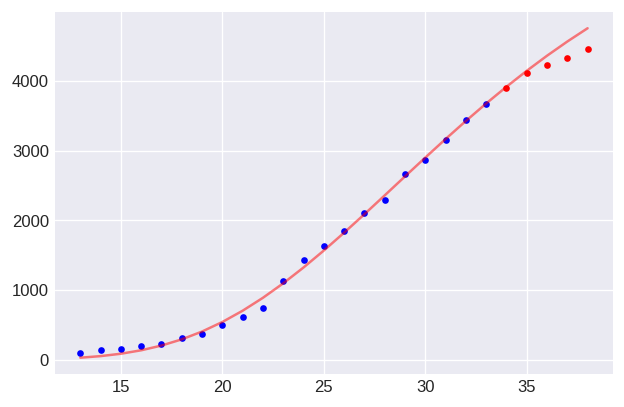

Ground truth: [3896 4107 4227 4335 4463]
Predicted: [3916 4144 4361 4565 4755]
RMSE: 178.11986002708406
Relative error: 0.0329858859425413


In [10]:
val_size = 5

x_train = x[:-val_size]
y_train = y[:-val_size]
#dydx_train = dydx[:-val_size]

x_val = x[-val_size:]
y_val = y[-val_size:]

model = gompertz_simple
params0 = [10000, 1000, 15]
names = ["A", "u", "d"]

params = fit_model(model, x_train, y_train, params0=params0)
params = dict(zip(names, params))

y_pred = model(x, **params)

plt.figure(dpi=120)
plt.plot(x_train, y_train, "b.")
plt.plot(x_val, y_val, "r.")
plt.plot(x, y_pred, "r-", alpha=.5)
plt.show()

print("Ground truth:", y_val)
print("Predicted:", y_pred[-val_size:].astype(int))

rmse = np.sqrt(np.mean((y_pred[-val_size:]-y_val)**2))
print("RMSE:", rmse)

relative = np.abs(y_pred[-val_size:] - y_val) / y_val
print("Relative error:", np.mean(relative))

In [11]:
y_val_diary = np.diff(y[-(val_size + 1):])
y_pred_diary = np.diff(y_pred)

print("Ground truth:", y_val_diary)
print("Predicted:", y_pred_diary[-val_size:].astype(int))

relative = np.abs(y_pred_diary[-val_size:] - y_val_diary) / y_val_diary
print("Relative error:", np.mean(relative))

Ground truth: [223 211 120 108 128]
Predicted: [240 228 216 203 190]
Relative error: 0.46826179381734195


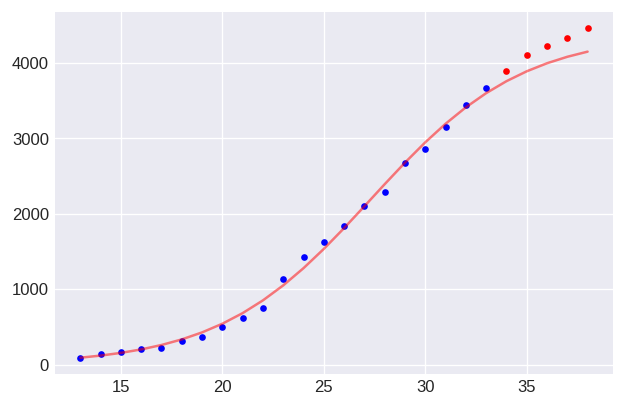

RMSE: 235.2264732284708


In [12]:
val_size = 5

x_train = x[:-val_size]
y_train = y[:-val_size]
#dydx_train = dydx[:-val_size]

x_val = x[-val_size:]
y_val = y[-val_size:]

model = tanh_KM_cdf
names = ["a", "b", "c"]
params0 = None

params = fit_model(model, x_train, y_train, params0=params0)
params = dict(zip(names, params))

y_pred = model(x, **params)

plt.figure(dpi=120)
plt.plot(x_train, y_train, "b.")
plt.plot(x_val, y_val, "r.")
plt.plot(x, y_pred, "r-", alpha=.5)
plt.show()

rmse = np.sqrt(np.mean((y_pred[-val_size:]-y_val)**2))
print("RMSE:", rmse)

In [13]:
y_val_diary = np.diff(y[-(val_size + 1):])
y_pred_diary = np.diff(y_pred)

print("Ground truth:", y_val_diary)
print("Predicted:", y_pred_diary[-val_size:].astype(int))

relative = np.abs(y_pred_diary[-val_size:] - y_val_diary) / y_val_diary
print("Relative error:", np.mean(relative))

Ground truth: [223 211 120 108 128]
Predicted: [158 131 106  85  68]
Relative error: 0.2896544911540892


# Modelos por provincia

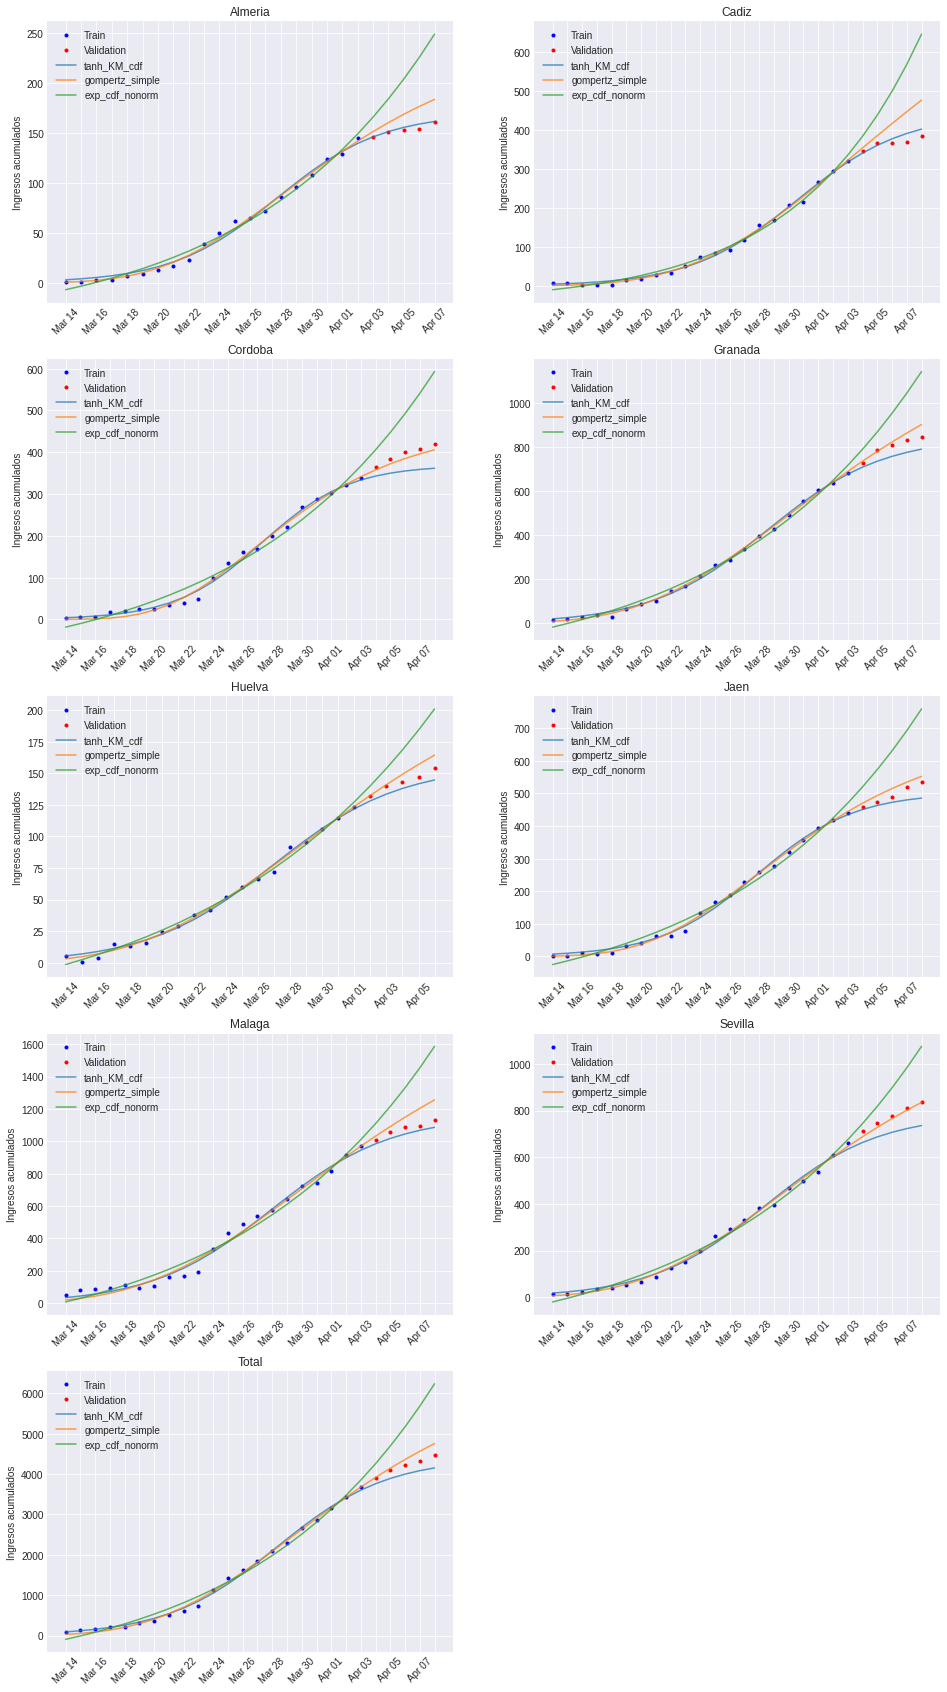

In [14]:
dic_models = {"tanh_KM_cdf": {'a': 50, 'b': 0.13, 'c': 3},
             "gompertz_simple": {"A": 10000, "u": 1000, "d": 15},
             "exp_cdf_nonorm": ["a", "b", "c"]}

val_size = 5
regions = sorted(df.region.unique())

n_plots = len(regions)
ncols = 2
nrows = (n_plots+1)//ncols

plt.figure(figsize=(8*ncols, 6*nrows))

for i, region in enumerate(regions):
    
    plt.subplot(nrows, ncols, i+1)
    plt.title(region.title())
    
    x, y, dydx = preprocess_data(df, region, fecha_inicio)
    
    x_train = x[:-val_size]
    y_train = y[:-val_size]

    x_val = x[-val_size:]
    y_val = y[-val_size:]
    
    assert x_train[-1] != x_val[0], "¡Estas repitiendo puntos!"
    
    plt.plot(x_train, y_train, "b.")
    plt.plot(x_val, y_val, "r.")
    
    for model, params in dic_models.items():
        if type(params) == dict:
            names = list(params.keys())
            params0 = list(params.values())
        else:
            names = params
            params0 = None
            
        best_params = fit_model(eval(model), x_train, y_train, params0=params0)
        best_params = dict(zip(names, best_params))
        
        y_pred = eval(model)(x, **best_params)

        plt.plot(x, y_pred, alpha=.75)
        
    # Ticks
    labels = [""] * df.index.nunique()
    labels[::2] = [item.strftime('%b %d') for item in df.index.unique()[::2]]
    plt.xticks(x, labels, rotation=45)
    
    plt.legend(["Train", "Validation"] + list(dic_models.keys()))
    plt.ylabel("Ingresos acumulados")

plt.show()

# Modelos por Comunidad Autónoma

In [17]:
from preprocessing.isciii import preprocess_isciii

url = "https://covid19.isciii.es/resources/serie_historica_acumulados.csv"
dataset = pd.read_csv(url, encoding='latin1')
dataset = preprocess_isciii(dataset, daily=False)

In [18]:
dic_models = {"tanh_KM_cdf": {'a': 50, 'b': 0.13, 'c': 3},
             "gompertz_simple": {"A": 10000, "u": 1000, "d": 15},
             "exp_cdf_nonorm": ["a", "b", "c"]}

val_size = 5
regions = sorted(dataset.region.unique())

n_plots = len(regions)
ncols = 2
nrows = (n_plots+1)//ncols

plt.figure(figsize=(8*ncols, 6*nrows))

for i, region in enumerate(regions):
    
    plt.subplot(nrows, ncols, i+1)
    plt.title(region.title())
    
    x, y, dydx = preprocess_data(dataset, region, fecha_inicio)
    
    x_train = x[:-val_size]
    y_train = y[:-val_size]

    x_val = x[-val_size:]
    y_val = y[-val_size:]
    
    assert x_train[-1] != x_val[0], "¡Estas repitiendo puntos!"
    
    plt.plot(x_train, y_train, "b.")
    plt.plot(x_val, y_val, "r.")
    
    for model, params in dic_models.items():
        if type(params) == dict:
            names = list(params.keys())
            params0 = list(params.values())
        else:
            names = params
            params0 = None
            
        best_params = fit_model(eval(model), x_train, y_train, params0=params0)
        best_params = dict(zip(names, best_params))
        
        y_pred = eval(model)(x, **best_params)

        plt.plot(x, y_pred, alpha=.75)
    
    plt.legend(["Train", "Validation"] + list(dic_models.keys()))
    plt.ylabel("Ingresos acumulados")
    plt.xlabel("Día (a partir del 1 de marzo)")

plt.show()

../src/prediction/fit.py:69: UserWarning: parameters not found using params0, params1 used
  warnings.warn('parameters not found using params0, params1 used')
../src/prediction/fit.py:73: UserWarning: parameters not found, try to change initial parameters
  warnings.warn(msg)


TypeError: zip argument #2 must support iteration

In [19]:
df[df.region=='total'].ingreso

dia
2020-03-14      93
2020-03-15     134
2020-03-16     160
2020-03-17     200
2020-03-18     223
2020-03-19     307
2020-03-20     367
2020-03-21     503
2020-03-22     616
2020-03-23     744
2020-03-24    1132
2020-03-25    1433
2020-03-26    1626
2020-03-27    1843
2020-03-28    2106
2020-03-29    2294
2020-03-30    2671
2020-03-31    2867
2020-04-01    3147
2020-04-02    3444
2020-04-03    3673
2020-04-04    3896
2020-04-05    4107
2020-04-06    4227
2020-04-07    4335
2020-04-08    4463
Name: ingreso, dtype: int64

In [20]:
from prediction.fit import _fit_model_and_predict
y_pred = _fit_model_and_predict(tanh_KM_cdf,x,y,n_pred=5)
print(y_pred)
# np.diff(np.concat((,y_pred)))

[9.66265708 9.76157241 9.82798275 9.872317   9.90180148]


../src/prediction/fit.py:108: UserWarning: model not fitted, impossible to predict
  warnings.warn('model not fitted, impossible to predict')


TypeError: Gompertz() argument after * must be an iterable, not NoneType

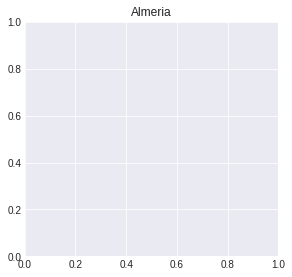

In [21]:
fecha_inicio = dt.datetime(2020,3,1)

regions = sorted(df.region.unique())
n_plots = len(regions)
ncols = 2
nrows = (n_plots+1)//ncols
plt.figure(figsize=(5*ncols,5*nrows))

for i, region in enumerate(regions):
    x, y, dydx = preprocess_data(df, region, fecha_inicio)

    plt.subplot(nrows, ncols, i+1)
    plt.title(region.title())
    temporal_validation_metric(gompertz_simple, x, y,params0=[10000, 1000, 15], plot=True,plot_kwargs={'linestyle':':'})
    temporal_validation_metric(exp_cdf_nonorm, x, y,plot=True,plot_kwargs={'linestyle':'-.'})
    temporal_validation_metric(tanh_KM_cdf, x, y, params0=[300,.1,10],plot=True)
    
    plt.ylim(0,1)
    
# plt.show()

In [22]:
from inspect import signature
import matplotlib.ticker as ticker

def plot_results_fit(model,params,x,y, fecha_inicio, predicted_days = 10, max_pop = 12e6):
    """
    Plot model prediction and data points:
        * Cumulative cases vs t
        * Daily cases vs t
        * Daily cases vs Cumulative cases (Log Log scale)
    """
    assert len(params) == len(signature(model).parameters) - 1
    date_format = '%b %d'
    
    dydx = np.diff(y)
    
    x_pred = np.arange(x.min()-1, x.max() + predicted_days+1, 1)
    y_pred = model(x_pred, *params)
    dydx_pred = np.diff(y_pred)
    
    x_next_day = int(x.max()+1)
    y_next_day = int(y_pred[x_pred==x_next_day])
    delta_cases_next_day = y_next_day-int(y[-1])
    fecha_next_day = (fecha_inicio+x_next_day*dt.timedelta(days=1)).strftime(date_format)

    y_asymp = int(np.min( (model(1000, *params), max_pop)))
    
    title = f"{fecha_next_day}: Nuevos {delta_cases_next_day} / Total {y_next_day}\nCasos asintóticos: {y_asymp}"
    plt.figure(dpi=100,figsize=(12,4))
    plt.suptitle(title)

    # cumulativa
    plt.subplot(1,2,1)
    sns.scatterplot(x, y)
    sns.lineplot(x_pred, y_pred, color="red")
    plt.xlabel(f"Dia")
    plt.ylabel("Casos acumulados")

    ticklabels = plt.xticks()[0]
    ticklabels = [(fecha_inicio+dt.timedelta(days=int(item))).strftime(date_format) for item in ticklabels]
    plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate(rotation=45, ha='center')

    #casos por dia
    plt.subplot(1,2,2)
    sns.scatterplot(x[1:], dydx)
    sns.lineplot(x_pred[1:], dydx_pred, color="red")
    plt.xlabel(f"Dia")
    plt.ylabel("Casos diarios")
    
    ticklabels = plt.xticks()[0]
    ticklabels = [(fecha_inicio+dt.timedelta(days=int(item))).strftime(date_format) for item in ticklabels]
    plt.gca().xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate(rotation=45, ha='center')

#     # curva implícita
#     plt.subplot(1,3,3)
#     sns.scatterplot(y,dydx)
#     sns.lineplot(y_pred[1:],dydx_pred, color='red')
#     plt.xscale("log")
#     plt.yscale("log")
#     plt.xlabel("Casos totales")
#     plt.ylabel("Casos diarios")
#     plt.show()